In [46]:
import pandas as pd  
import numpy as np  
import seaborn as sns  
import matplotlib.pyplot as plt  
from sklearn.metrics import silhouette_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
data_customers = pd.read_csv('Wholesale_customers_data.csv')
data_customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


The data set is from [UCI ML repo](https://archive.ics.uci.edu/ml/datasets/wholesale+customers)

**Abstract**: The data set refers to clients of a wholesale distributor. They've given us the deets on how much their clients spend in monetary units m.u. on all sorts of different product categories.

In [6]:
data_customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Let's explore, this dataset using unsupersived Machine learning methods. 

**Use Case**: Clustering algorithms aid customer segmentation in business by grouping similar customers together based on characteristics and behaviors. This helps companies create tailored marketing strategies for each segment, resulting in better customer understanding and satisfaction.

We wanna figure out what kind of peeps we've got in our data. To do that, we're gonna sort them into squads based on how alike they are. If two customers are best buds in a group, they gotta be more similar than if they're in different groups.
Once we've done that, we can look at each squad and see what they like to buy. 

In clustering, we are not trying to predict any true values and we don't have prior knowledge of the appropriate number of groups to identify in the data.

## Pre processing

For the customer segmentation, let's remove information about Area from the data. 
The 'Channel' is like a code that tells us if our customer is from the Shire (hotel), Rohan (restaurant), or Lothlórien (cafe). And 'Region' gives us the scoop on where they're from, whether it's the Misty Mountains, Fangorn Forest, or the Dead Marshes.

In [11]:
data_customers_v1 = data_customers.iloc[:,2:]

Before we chuck our data into the ring for the clustering algorithm to sort out, we gotta weed out any pesky outliers. Sure, they're not a huge problem here, but why not give our results a boost by doing this first? Let's look at the boxplots for each of the features and then remove the outliers.

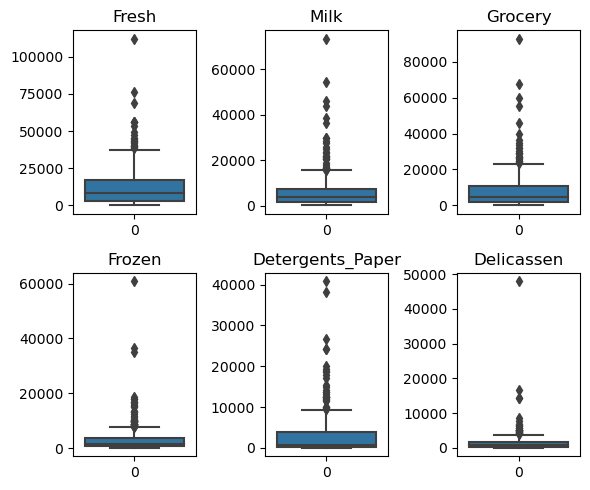

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(6, 5))

for i, ax in enumerate(axes.flatten()):
    if i < len(data_customers_v1.columns):
        sns.boxplot(data_customers_v1[data_customers_v1.columns[i]], ax=ax)
        ax.set_title(data_customers_v1.columns[i])
    else:
        ax.axis('off')

plt.tight_layout()

In [20]:
data_customers_v1.quantile(0.25)

Fresh               3127.75
Milk                1533.00
Grocery             2153.00
Frozen               742.25
Detergents_Paper     256.75
Delicassen           408.25
Name: 0.25, dtype: float64

In [33]:
Q1 = data_customers_v1.quantile(0.25)
Q3 = data_customers_v1.quantile(0.75)
IQR = Q3 - Q1
IQR

Fresh               13806.00
Milk                 5657.25
Grocery              8502.75
Frozen               2812.00
Detergents_Paper     3665.25
Delicassen           1412.00
dtype: float64

### Removing the outliers

In [36]:
outlier_indexes = []

# Define the upper and lower bounds as 1.5 times the IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

for col in data_customers_v1.columns:
    outlier_mask = (data_customers_v1[col] < lower_bound[col]) | (data_customers_v1[col] > upper_bound[col])
    outlier_indexes.extend(data_customers_v1.index[outlier_mask])

# Remove the outliers by dropping the rows with outlier indexes
data_customers_v1_outliers_removed = data_customers_v1.drop(index=set(outlier_indexes))

# Print the number of removed outliers and the shape of the updated dataset
print("Number of removed outliers:", len(outlier_indexes))
print(f"The shape of the dataset before removing outliers: {data_customers_v1.shape}")
print("Updated dataset shape:", data_customers_v1_outliers_removed.shape)


Number of removed outliers: 172
The shape of the dataset before removing outliers: (440, 6)
Updated dataset shape: (332, 6)


## KMeans Clustering

When we use K-Means clustering, we need to measure the distance between data points to group them together. That means we need to make sure all the features are on the same scale, or else some features might appear more important than others (like comparing hobbits to elves, which isn't a fair comparison because they have different abilities and attributes).

For our customers data, all the spending features are in the same units, so scaling might not matter too much. But we still need to be cautious! If we had features like customer age and income, scaling would be crucial to ensure that no one feature unfairly dominates the clustering process.

### Scaling

In [37]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

data_customers_v1_outliers_removed_scaled = pd.DataFrame(std_scaler.fit_transform(data_customers_v1_outliers_removed), columns=data_customers_v1_outliers_removed.columns)
data_customers_v1_outliers_removed_scaled.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.383041,1.652898,0.334978,-0.967004,0.305053,0.390465
1,-0.305588,1.698756,0.733878,-0.059255,0.569139,0.922591
2,0.456174,-0.866283,-0.328862,2.662821,-0.619462,0.937169
3,-0.016491,1.236906,-0.148989,-0.701951,-0.069958,0.527749
4,0.316411,-0.269838,0.218508,-0.811022,0.503864,-0.572949


### Data projection

We don't need a wizard to cast a spell to reduce the dimensions of our data. We can use a Principal Component Analysis (PCA) transformer to work its magic and project our data into a lower-dimensional space.

We can reduce the number of features in a dataset while still preserving the most important information. 

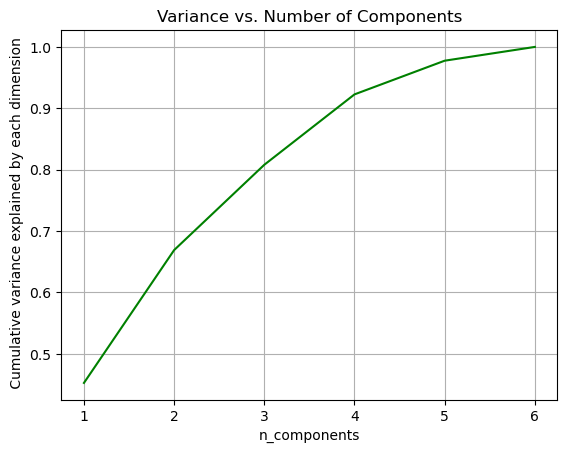

In [43]:
from sklearn.decomposition import PCA
num_features = data_customers_v1_outliers_removed_scaled.shape[1]
pca = PCA(n_components=num_features)

data_custom_pca_transformed = pca.fit_transform(data_customers_v1_outliers_removed_scaled)

plt.plot(range(1, data_customers_v1_outliers_removed_scaled.shape[1]+1), pca.explained_variance_ratio_.cumsum(), 'g')
plt.grid()
plt.xlabel("n_components")
plt.ylabel("Cumulative variance explained by each dimension")
plt.title("Variance vs. Number of Components");

We can capture upto 80% variance in our data using only 3 principal components

Let's get rid of other 3 components. For that we need to project our data into 3D, we'll use a PCA transformer. It will project our data onto a new 3D subspace defined by the first 3 components.

In [50]:
pca3D = PCA(n_components=3)
data_custom_pca_3D = pca3D.fit_transform(data_customers_v1_outliers_removed_scaled)

Let's observe the performance of KMeans for number of clusters in the range (2,6)

In [52]:
from sklearn.cluster import KMeans

for n_clust in range(2,9):
    kmc = KMeans(n_clusters = n_clust)
    kmc.fit(data_custom_pca_3D)
    predictions = kmc.predict(data_custom_pca_3D)
    #Cluster metrics
    sil_score = silhouette_score(data_custom_pca_3D,predictions, metric = 'euclidean')
    
    print(f"For {n_clust} number of clusters, the avg silhouette score is {sil_score.round(4)} ")

For 2 number of clusters, the avg silhouette score is 0.4225 
For 3 number of clusters, the avg silhouette score is 0.3476 
For 4 number of clusters, the avg silhouette score is 0.3657 
For 5 number of clusters, the avg silhouette score is 0.3625 
For 6 number of clusters, the avg silhouette score is 0.3279 
For 7 number of clusters, the avg silhouette score is 0.3028 
For 8 number of clusters, the avg silhouette score is 0.3121 


The Silhouette metric is like a judge for your clustering party. It looks at how well your data points fit into their assigned clusters, and how different they are from other clusters. A high Silhouette score means the guests are happily mingling within their own clusters and not crashing other clusters, while a low score means some guests are feeling left out and may need to switch clusters.

so we choose optimal number of clusters as 2 because it has the highest score.

In [101]:
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import IntSlider
from ipywidgets import interact

n_clust = 2
kmc = KMeans(n_clusters=n_clust, n_init=10)
kmc.fit(data_custom_pca_3D)

cols = kmc.predict(data_custom_pca_3D)

colors = ['red', 'blue']
centroids = kmc.cluster_centers_

def plot_kmc_clus(azimuth, elevation):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.view_init(elev=elevation, azim=azimuth)

    x = data_custom_pca_3D[:,0]
    y = data_custom_pca_3D[:,1]
    z = data_custom_pca_3D[:,2]
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3', rotation=90, labelpad=-2)
    ax.scatter(x, y, z, marker='*', s=8, color=[colors[col] for col in cols])

interact(plot_kmc_clus, azimuth=IntSlider(min=0, step=20, value=50, description='horizontal_angle(Azimuth)'), 
                      elevation=IntSlider(min=0, step=20, value=20, description='vertical_angle (Elevation)'));

interactive(children=(IntSlider(value=50, description='horizontal_angle(Azimuth)', step=20), IntSlider(value=2…

In [97]:
centroids

array([[ 2.1588193 ,  0.11748695,  0.04422571],
       [-0.95738943, -0.05210291, -0.01961314]])

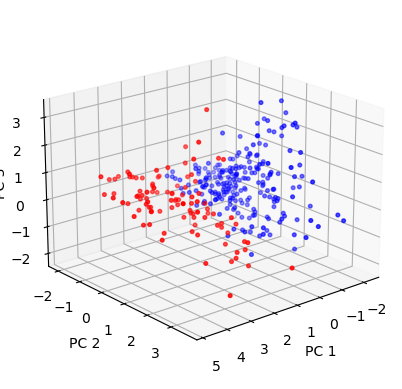

In [99]:
##figure without using interact option
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=50)
x = customers_pca_3D[:,0]
y = customers_pca_3D[:,1]
z = customers_pca_3D[:,2]
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3', rotation=90, labelpad=-2)
ax.scatter(x, y, z, marker='o', s=7, color=[colors[col] for col in cols])

### Interpreting the clustering results

After projecting our data onto a lower-dimensional space, we might want to recover the original information so that we can analyze and interpret it. In order to do this, we'll need to apply an inverse transformation to our PCA-reduced data.

We are going to look at a behaviour of typical customers, let's say these come from the centroids of the above two clusters.
We should note that representative are not real individuals, but rather are an artificial construct created by the clustering algorithm.

In [77]:
#Scaling --> PCA --> Clustering

# inverse data scaling done by PCA
scaled_centroids = pca3D.inverse_transform(centroids)
# invert the scaler
true_centroids = std_scaler.inverse_transform(scaled_centroids)

In [75]:
scaled_centroids

array([[ 0.09962597, -0.50788509, -0.54291468,  0.13641538, -0.52872082,
        -0.24271402],
       [-0.22464679,  1.14523109,  1.22421937, -0.30760331,  1.19221362,
         0.54729632]])

In [92]:
typical_customers = pd.DataFrame(true_centroids, columns = data_customers_v1.columns, 
                                 index=['Representative customer 1', 'Representative customer 2'])
typical_customers['total_expenses'] = typical_customers.sum(axis=1)
typical_customers

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,total_expenses
Representative customer 1,10359.302411,2399.583680,3144.028143,2095.679564,719.690104,816.821019,19535.104920
Representative customer 2,7716.631818,7951.134839,12035.073796,1338.487259,4753.443883,1467.089860,35261.861455


The first representative customer tends to spend more on fresh products, while the second rep customer spends more on grocery and detergents/paper products.

The 1st one loves chugging milk but ain't too interested in buying detergents and paper stuff. 

It is also interesting to see that the 1st one spends more on Fresh and Frozen products both and I expected that the people who spends more on frozen products might spend less on the Fresh products!!

Overall, this table gives us an idea of the kinds of products that are most important for each representative customer, which can help us make decisions about how to market to those customers or what products to prioritize.